Script de medición y carga de las colecciones en cluster MongoDB
TFM Daniel Herranz Segundo

In [257]:
import pandas as pd
import numpy as np
import os
import json
import random
import pymongo
from pymongo import MongoClient
import time
from pprint import pprint
from pymongo import InsertOne, DeleteMany, ReplaceOne, UpdateOne
import matplotlib.pyplot as plt
import psutil

In [258]:
#Variables de los ficheros de datos salida
CurrentAccountCollection_file_out = '../MockData/MongoDB/CurrentAccountCollection/CurrentAccountCollection.json'
PositionKeepingCollection_file_out = '../MockData/MongoDB/PositionKeepingCollection/PositionKeepingCollection.json'
CustomerProfileCollection_file_out = '../MockData/MongoDB/CustomerProfileCollection/CustomerProfileCollection.json'

CurrentAccountCollection_sample_out = '../MockData/MongoDB/CurrentAccountCollection/CurrentAccountCollection_sample.json'
PositionKeepingCollection_sample_out = '../MockData/MongoDB/PositionKeepingCollection/PositionKeepingCollection_sample.json'
CustomerProfileCollection_sample_out = '../MockData/MongoDB/CustomerProfileCollection/CustomerProfileCollection_sample.json'

In [259]:
resultados_etl_CutomerProfileCollection = '../MockData/MongoDB/CustomerProfileCollection/CustomerProfileCollection_{}.csv'
resultados_etl_PositionKeepingCollection = '../MockData/MongoDB/PositionKeepingCollection/resultsPositionKeepingCollection_{}.csv'
resultados_etl_CurrentAccountCollection = '../MockData/MongoDB/CurrentAccountCollection/CurrentAccountCollection_{}.csv'

In [260]:
#repeticiones
repeats = 1000


In [284]:
#Conexion unica a colecciones
connection = MongoClient('localhost', 27017, w=3) #Conexion con WriteConcern a 3 (primario y dos nodos consolidados)

#Creamos una base de datos para el trabajo llamada TFM
tfm_mongo_db = connection["tfm_mongo_database"]

## Creación de las colecciones por cada dominio

In [285]:
CustomerProfileCollection = tfm_mongo_db["CustomerProfileCollection"]
CurrentAccountCollection = tfm_mongo_db["CurrentAccountCollection"]
PositionKeepingCollection = tfm_mongo_db["PositionKeepingCollection"]
print(connection.list_database_names())

['admin', 'config', 'local', 'tfm_mongo_database']


## Carga de los documentos por cada dominio

### Test de carga CustomerProfileCollection

In [273]:
#Carga de la información de dataframes por entidades
CustomerProfileCollection_df = pd.read_json(CustomerProfileCollection_sample_out) #Carga Sample
CurrentAccountCollection_df = pd.read_json(CurrentAccountCollection_sample_out) #Carga Sample
PositionKeepingCollection_df = pd.read_json(PositionKeepingCollection_sample_out) #Carga Sample

In [274]:
print("CustomerProfileCollection_df",len(CustomerProfileCollection_df))
print("CurrentAccountCollection_df",len(CurrentAccountCollection_df))
print("PositionKeepingCollection_df",len(PositionKeepingCollection_df))

CustomerProfileCollection_df 1000
CurrentAccountCollection_df 10000
PositionKeepingCollection_df 10000


In [275]:
for x in range(17): # Generamos un millon de registros aprox
    CustomerProfileCollection_df = CustomerProfileCollection_df.append(CustomerProfileCollection_df.sample(frac=0.50,replace = True))
    CurrentAccountCollection_df = CurrentAccountCollection_df.append(CurrentAccountCollection_df.sample(frac=0.32,replace = True))
    PositionKeepingCollection_df = PositionKeepingCollection_df.append(PositionKeepingCollection_df.sample(frac=0.32,replace = True))

print("CustomerProfileCollection_df",len(CustomerProfileCollection_df))
print("CurrentAccountCollection_df",len(CurrentAccountCollection_df))
print("PositionKeepingCollection_df",len(PositionKeepingCollection_df))

985391
1121405
1121405


In [278]:
#Cargas Masiva con Many
def loadCollectionDataFrame(df):
    registers = []
    grps = df.groupby(df.index / 1000)    
    iter = 0;
    for i,group_df in grps: 
        #Insertamos en bloques de 1000 para igualar a otros motores    
        time_inicial = time.time()
        CurrentAccountCollection.insert_many(group_df.to_dict('records'))
        time_final = time.time()
        data_time_collection = time_final - time_inicial
        used_cpu = psutil.cpu_percent()
        mem_used = psutil.virtual_memory().percent
        registers.append((iter,data_time_collection,used_cpu,mem_used))
        iter += 1000;
    return registers

In [279]:
# Impresión de resultados
def printResults(registers):
    results_collection = list(zip(*registers))
    average = round(np.average(results_collection[1]),2)
    max_trx = round(max(results_collection[1]),2)
    min_trx = round(min(results_collection[1]),4)
    average_cpu = round(np.average(results_collection[2]),2)
    max_cpu = round(max(results_collection[2]),2)
    min_cpu = round(min(results_collection[2]),2)
    average_mem = round(np.average(results_collection[3]),2)
    max_mem = round(max(results_collection[3]),2)
    min_mem = round(min(results_collection[3]),4)
    print("ROWS INSERTED:", len(results_collection[1]) * 1000, ' Total rows')
    print("TOTAL TIME:" , round(sum(results_collection[1]),2), 'seg')
    print("AVG INSERT TIME:" , average, 'seg')
    print("MAX INSERT TIME:" , max_trx, 'seg')
    print("MIN INSERT TIME:" , min_trx, 'seg')
    print("AVG INSERT CPU USE:" , average_cpu, '%')
    print("MAX INSERT CPU USE:" , max_cpu, '%')
    print("MIN INSERT CPU USE:" , min_cpu, '%')
    print("AVG INSERT MEM IN USE:" , average_mem, '%')
    print("MAX INSERT MEM IN USE:" , max_mem, '%')
    print("MIN INSERT MEM IN USE:" , min_mem, '%')

In [281]:
def plotResults(reg, collection_name):
    
    average = round(np.average(registers[1]),2)
    average_cpu = round(np.average(registers[2]),2)
    average_mem = round(np.average(registers[3]),2)
   
    #Transacciones
    plt.plot(reg[0],reg[1])
    plt.title("MongoDB # Carga masiva {} #".format(collection_name))
    plt.xlabel("Insercciones")
    plt.ylabel("Tiempo(s)")
    plt.axhline(average, color='g', linestyle='--',label='Media ejecución Trx.')
    plt.axhline(min_trx, color='b', linestyle='--',label='Media ejecución Trx.')
    plt.axhline(max_trx, color='r', linestyle='--',label='Media ejecución Trx.')
    plt.show()

    #CPU
    plt.plot(reg[0],reg[2])
    plt.title("MongoDB # Carga masiva {} #".format(collection_name))
    plt.xlabel("Documentos insertados")
    plt.ylabel("% CPU en uso")
    plt.axhline(average_cpu, color='g', linestyle='--',label='Media ejecución Trx.')
    plt.axhline(min_cpu, color='b', linestyle='--',label='Media ejecución Trx.')
    plt.axhline(max_cpu, color='r', linestyle='--',label='Media ejecución Trx.')
    plt.show()

    #Memoria
    plt.plot(reg[0],reg[3])
    plt.title("MongoDB # Carga masiva {} #".format(collection_name))
    plt.xlabel("Documentos insertados")
    plt.ylabel("% Memoria en uso")
    plt.show()

In [282]:
def save_results_to_csv(results,file):
    #Guardamos los resultados en csv
    from datetime import datetime
    data = {
        "Registros" : results[0],
        "Tiempo" : results[1],
        "CPU" : results[2],
        "Memoria" : results[3],
    }
    csv_df = pd.DataFrame(data)
    dia = datetime.now().strftime("%d%m%Y_%H_%M_%S")
    csv_df.to_csv(file.format(str(dia)))

In [286]:
#Borramos los valores actuales de la colección
connection["tfm_mongo_database"].CustomerProfileCollection.drop()
print('Borrada colleción CustomerProfileCollection')

NotMasterError: not master, full error: {'topologyVersion': {'processId': ObjectId('624db3c64edd03fc7cd0773c'), 'counter': 8}, 'ok': 0.0, 'errmsg': 'not master', 'code': 10107, 'codeName': 'NotWritablePrimary', '$clusterTime': {'clusterTime': Timestamp(1649270825, 1), 'signature': {'hash': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'keyId': 0}}, 'operationTime': Timestamp(1649270825, 1)}

In [245]:
registers_customer_profile = loadCollectionDataFrame(CustomerProfileCollection_df)

In [253]:
save_results_to_csv(registers_customer_profile,resultados_etl_CutomerProfileCollection)

In [248]:
printResults(registers_customer_profile)

ROWS INSERTED: 1000000  Total rows
TOTAL TIME: 36.61 seg
AVG INSERT TIME: 0.04 seg
MAX INSERT TIME: 0.21 seg
MIN INSERT TIME: 0.0034 seg
AVG INSERT CPU USE: 34.28 %
MAX INSERT CPU USE: 90.0 %
MIN INSERT CPU USE: 0.0 %
AVG INSERT MEM IN USE: 91.87 %
MAX INSERT MEM IN USE: 96.4 %
MIN INSERT MEM IN USE: 90.2 %


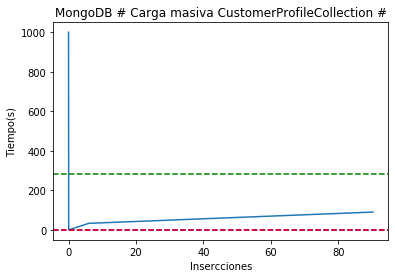

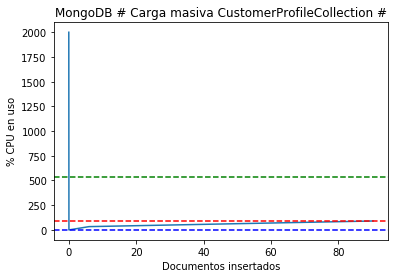

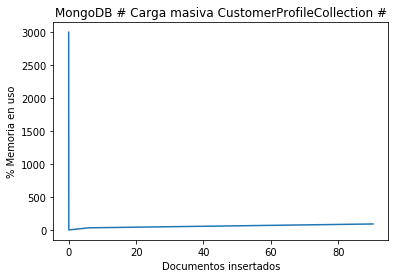

In [251]:
plotResults(registers,"CustomerProfileCollection")

# CurrentAccountCollection ETL Load

In [256]:
#Borramos los valores actuales de la colección
connection["tfm_mongo_database"].CurrentAccountCollection.drop()
print('Borrada colleción CurrentAccountCollection')

NotMasterError: not master, full error: {'topologyVersion': {'processId': ObjectId('624db3c64edd03fc7cd0773c'), 'counter': 8}, 'ok': 0.0, 'errmsg': 'not master', 'code': 10107, 'codeName': 'NotWritablePrimary', '$clusterTime': {'clusterTime': Timestamp(1649270114, 1), 'signature': {'hash': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'keyId': 0}}, 'operationTime': Timestamp(1649270114, 1)}

In [255]:
registers_CurrentAccount = loadCollectionDataFrame(CurrentAccountCollection_df)

BulkWriteError: batch op errors occurred, full error: {'writeErrors': [], 'writeConcernErrors': [{'code': 11602, 'codeName': 'InterruptedDueToReplStateChange', 'errmsg': 'operation was interrupted', 'errInfo': {'writeConcern': {'w': 3, 'wtimeout': 0, 'provenance': 'clientSupplied'}}}], 'nInserted': 2641, 'nUpserted': 0, 'nMatched': 0, 'nModified': 0, 'nRemoved': 0, 'upserted': []}

In [236]:
save_results_to_csv(registers_CurrentAccount,resultados_etl_Cur)

ROWS INSERTED: 98524370000  Total rows
TOTAL TIME: 284.12 seg
AVG INSERT TIME: 0.03 seg
MAX INSERT TIME: 0.89 seg
MIN INSERT TIME: 0.0018 seg
AVG INSERT CPU USE: 35.74 %
MAX INSERT CPU USE: 100.0 %
MIN INSERT CPU USE: 0.0 %
AVG INSERT MEM IN USE: 89.27 %
MAX INSERT MEM IN USE: 95.5 %
MIN INSERT MEM IN USE: 87.7 %


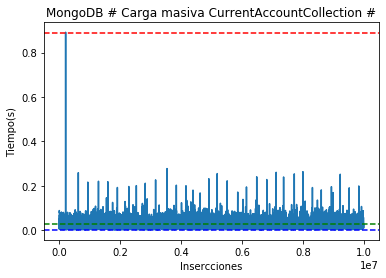

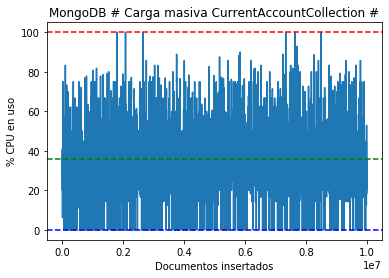

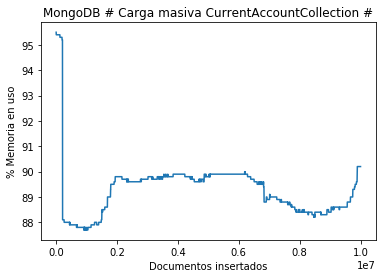

In [237]:
plotResults(registers_CurrentAccount,"CurrentAccount")

In [238]:
#Guardamos los resultados en csv
from datetime import datetime
data = {
    "Registros" : results_CurrentAccountCollection[0],
    "Tiempo" : results_CurrentAccountCollection[1],
    "CPU" : results_CurrentAccountCollection[2],
    "Memoria" : results_CurrentAccountCollection[3],
}
customerProfileETLResults = pd.DataFrame(data)
dia = datetime.now().strftime("%d%m%Y_%H_%M_%S")
customerProfileETLResults.to_csv(resultados_etl_CurrentAccountCollection.format(str(dia)))
customerProfileETLResults.sample(1)

,Registros,Tiempo,CPU,Memoria
1089,1089000,0.0461,35.7,87.8


## PositionKeepingCollection ETL Load

In [239]:
#Borramos los valores actuales de la colección
connection["tfm_mongo_database"].PositionKeepingCollection.drop()
print('Borrada colleción PositionKeepingCollection')

Borrada colleción PositionKeepingCollection


In [ ]:
registers_PositionKeeping = loadCollectionDataFrame(PositionKeepingCollection_df)

In [ ]:
save_results_to_csv(registers_PositionKeeping,resultados_etl_PositionKeepingCollection)

In [ ]:
printResults(registers_PositionKeeping)

In [ ]:
plotResults(registers_PositionKeeping,"PositionKeeping")

In [204]:
#Cierre de la conexion
connection.close()